# GARCH Optiver Realized Volatility Prediction

# Realized volatility
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called **volatility**. 

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the **realized volatility, $\sigma$,** as the squared root of the sum of squared log returns.
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$
Where we use **WAP** as price of the stock to compute log returns.

We want to keep definitions as simple and clear as possible, so that Kagglers without financial knowledge will not be penalized. So we are not annualizing the volatility and we are assuming that log returns have 0 mean.

# Competition data
In this competition, Kagglers are challenged to generate a series of short-term signals from the book and trade data of a fixed 10-minute window to predict the realized volatility of the next 10-minute window. The target, which is given in train/test.csv, can be linked with the raw order book/trade data by the same **time_id** and **stock_id**. There is no overlap between the feature and target window.

Note that the competition data will come with partitioned parquet file. You can find a tutorial of parquet file handling in this [notebook](https://www.kaggle.com/sohier/working-with-parquet)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob

path_vlad = '/Users/vladimir.levin/data/optiver-realized-volatility-prediction'
# path_laurent = ...

train = pd.read_csv(path_vlad + '/train.csv')
print(train.head())

# print(train['stock_id'].nunique())
# print(train['time_id'].unique())

Taking the first row of data, it implies that the realized vol of the **target bucket** for time_id 5, stock_id 0 is 0.004136. How does the book and trade data in **feature bucket** look like for us to build signals?

In [ ]:
book_example = pd.read_parquet(path_vlad + '/book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet(path_vlad + '/trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

**book data snapshot**

In [ ]:
print(book_example.shape)
#book_example.to_csv('test_book.csv')
book_example.head(10)

**trade date snapshot**

In [ ]:
trade_example.head()

**Realized volatility calculation in python**

In this competition, our target is to predict short-term realized volatility. Although the order book and trade data for the target cannot be shared, we can still present the realized volatility calculation using the feature data we provided. 

As realized volatility is a statistical measure of price changes on a given stock, to calculate the price change we first need to have a stock valuation at the fixed interval (1 second). We will use weighted averaged price, or WAP, of the order book data we provided.

In [ ]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

**The WAP of the stock is plotted below**

In [ ]:
#fig = px.line(book_example, x="seconds_in_bucket", y="wap", title='WAP of stock_id_0, time_id_5')
#fig.show()
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['wap'])
plt.xlabel('seconds in bucket')
plt.ylabel('wap')
plt.title('WAP of stock id 0 time id 5')
plt.show()

To compute the log return, we can simply take **the logarithm of the ratio** between two consecutive **WAP**. The first row will have an empty return as the previous book update is unknown, therefore the empty return data point will be dropped.

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [ ]:
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

**Let's plot the tick-to-tick return of this instrument over this time bucket**

In [ ]:
#fig = px.line(book_example, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['log_return'])
plt.xlabel('seconds in bucket')
plt.ylabel('log return')
plt.title('Log return of stock_id_0, time_id_5')
plt.show()

The realized vol of stock 0 in this feature bucket, will be:

In [ ]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

# Naive prediction: using past realized volatility as target

A commonly known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was in the initial 10 minutes.

Let's calculate the past realized volatility across the training set to see how predictive a single naive signal can be.

In [ ]:
import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob(path_vlad + '/book_train.parquet/*')

As the data is partitioned by stock_id in this competition to allow Kagglers better manage the memory, we try to calculcate realized volatility stock by stock and combine them into one submission file. Note that the stock id as the partition column is not present if we load the single file so we will remedy that manually. We will reuse the log return and realized volatility functions defined in the previous session.

In [ ]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # read the data
    df_book_data = pd.read_parquet(file_path) 
    
    # calculate WAP     
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                          df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                         (df_book_data['bid_size1']+ df_book_data['ask_size1'])
        
    # calculate log returns 
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    
    # calculater realized volatility
    df_realized_vol_per_stock =  \
        pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    # add row_id column to the data
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    # return the result
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

Looping through each individual stocks, we can get the past realized volatility as prediction for each individual stocks.

In [ ]:
def past_realized_volatility_per_stock(list_file, prediction_column_name):
    
    # create empty dataframe to store the result
    df_past_realized = pd.DataFrame()
    
    # loop through files, calculate realized volatility and append it to the result
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file, prediction_column_name)])
    return df_past_realized


# run the function to naively predict realized volatility
df_past_realized_train = past_realized_volatility_per_stock(list_file = list_order_book_file_train,
                                                           prediction_column_name = 'pred')

In [ ]:
#df_past_realized_train.to_csv('test_realized.csv')
df_past_realized_train

In [ ]:
train

Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.

In [ ]:
train_check = train
train_check['row_id'] = train_check['stock_id'].astype(str) + '-' + train_check['time_id'].astype(str)
train_check = train_check[['row_id','target']]
df_joined = train_check.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'right')

In [ ]:
df_joined

We will evaluate the naive prediction result by two metrics: RMSPE and R squared. 

In [ ]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

The performance of the naive model is not amazing but as a benchmark it is a reasonable start.

# GARCH volatility prediction

## Some return exploration first

Plot log returns for the whole day aggregated by `time_id` (10-minute intervals)

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf # for acf plots
from statsmodels.graphics.tsaplots import plot_pacf # for pacf plots
from arch import arch_model

In [ ]:
# select the stock
file_path = list_order_book_file_train[0]

# read the data
df_book_data = pd.read_parquet(file_path) 

# select time_id (select the first one available)
mytime_id = df_book_data['time_id'].unique()[1]

# subset the data
df_book_data = df_book_data[df_book_data['time_id'] == mytime_id]

# calculate WAP     
df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                      df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                     (df_book_data['bid_size1']+ df_book_data['ask_size1'])

# calculate log returns 
df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
df_book_data = df_book_data[~df_book_data['log_return'].isnull()]

# plot
fig = plt.figure()
fig.set_figwidth(12)
# plt.plot(df_book_data.groupby(['time_id'])['log_return'].agg(sum), label = '10-min Returns')
plt.plot(df_book_data['seconds_in_bucket'], df_book_data['log_return'], label = 'intra-10min Returns')
plt.legend(loc='upper right')
plt.title('Returns Over Time')
plt.show()

Lets plot the absolute values to check for clustering

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data['seconds_in_bucket'], np.abs(df_book_data['log_return']), label = 'intra-10min Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

Let's see the ACF function for returns:

In [ ]:
# create acf plot for log returns
plot_acf(df_book_data['log_return'])
pyplot.show()

In [ ]:
# create acf plot for absolute log retunrs
plot_acf(np.abs(df_book_data['log_return']))
pyplot.show()

The absolute returns do not look autocorrelated even if aggregated at hourly frequency. This makes me feel like those returns are not exactly sequential, and that GARCH model might not work well.

### Let's actually aggregate unevenly spaced returns into 1 second returns

In [ ]:
# select the stock
file_path = list_order_book_file_train[0]

# read the data
df_book_data = pd.read_parquet(file_path) 

# select time_id (select the first one available)
mytime_id = df_book_data['time_id'].unique()[1]

# subset the data
df_book_data = df_book_data[df_book_data['time_id'] == mytime_id]

# calculate WAP     
df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                      df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                     (df_book_data['bid_size1']+ df_book_data['ask_size1'])

In [ ]:
df_book_data_evenly = pd.DataFrame({'time_id':mytime_id, 'second':range(0,600)})

# the first row is always the same
df_evenly_remainder = df_book_data.iloc[0:1, 2:]


# create the rest of the table through a loop

for i in range(1, 600):
    df_evenly_remainder = df_evenly_remainder.append(df_book_data[df_book_data['seconds_in_bucket'] <= i].iloc[-1:, 2:])


# finally, reset the index and show the dataframe
df_evenly_remainder.reset_index(inplace=True, drop=True)

# concat two dataframes
df_book_data_evenly = pd.concat([df_book_data_evenly, df_evenly_remainder], axis=1)
df_book_data_evenly

In [ ]:
# calculate log returns 
df_book_data_evenly['log_return'] = df_book_data_evenly.groupby(['time_id'])['wap'].apply(log_return)
df_book_data_evenly = df_book_data_evenly[~df_book_data_evenly['log_return'].isnull()]

# plot
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data_evenly['second'], df_book_data_evenly['log_return'], label = '1 sec returns')
plt.legend(loc='upper right')
plt.title('Returns Over Time')
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data_evenly['second'], np.abs(df_book_data_evenly['log_return']), label = '1 sec Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

In [ ]:
# create acf plot for absolute log retunrs
plot_acf(np.abs(df_book_data_evenly['log_return']))
pyplot.show()

This looks more autocorrelated!

## Fitting  GARCH(1, 1) model

Estimating GARCH(1,1) for a 10-minute interval

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [181]:
N = 10000
model = arch_model(df_book_data_evenly['log_return'] * N, p=1, q=1)
model_fit = model.fit()
yhat = model_fit.forecast(horizon=600, reindex=True)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2787.0261316545416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5774.4734079566015
Iteration:      3,   Func. Count:     22,   Neg. LLF: 779.4350793311169
Iteration:      4,   Func. Count:     28,   Neg. LLF: 744.0893272397425
Iteration:      5,   Func. Count:     33,   Neg. LLF: 744.0881176847024
Iteration:      6,   Func. Count:     39,   Neg. LLF: 743.9270306500354
Iteration:      7,   Func. Count:     44,   Neg. LLF: 743.9165316395079
Iteration:      8,   Func. Count:     49,   Neg. LLF: 743.9103201230337
Iteration:      9,   Func. Count:     54,   Neg. LLF: 743.9102824561805
Iteration:     10,   Func. Count:     58,   Neg. LLF: 743.9102824589422
Optimization terminated successfully    (Exit mode 0)
            Current function value: 743.9102824561805
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10


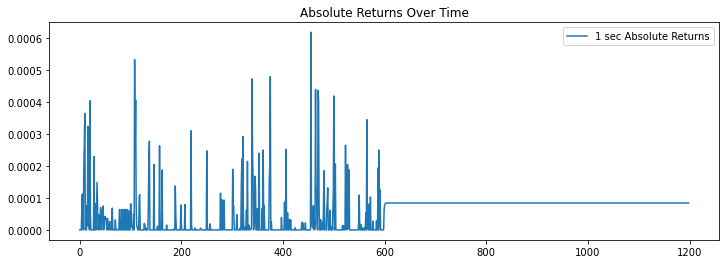

In [187]:
# # combine returns predictions with actual returns and plot
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(pd.concat([np.abs(df_book_data_evenly['log_return']), pd.Series(yhat.variance.values[-1,:] / N)]).reset_index(drop=True), label = '1 sec Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

Now lets compute the realized volatility of the past returns and the prediction

In [194]:
# past
past = realized_volatility(df_book_data_evenly['log_return'])

# GARCH prediction
predicted = realized_volatility(pd.Series(yhat.variance.values[-1,:] / N))

print(f'Realized volatility in: the interval = {round(past, 7)}, projected = : {round(predicted,7)}')

Realized volatility in: the interval = 0.0021547, projected = : 0.0020548


The volatility predicted by GARCH(1,1) model differs slightly from the naive prediction.

In [ ]:
train = pd.read_csv(path_vlad + '/train.csv')
train_check = train
train_check['row_id'] = train_check['stock_id'].astype(str) + '-' + train_check['time_id'].astype(str)
train_check = train_check[['row_id','target']]
df_joined = train_check.merge(data_by_timeid_wpred[['row_id','pred']], on = ['row_id'], how = 'right')

In [ ]:
df_joined

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_joined['target'])
plt.plot(df_joined['pred'])
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['Target', 'Prediction'])
plt.show()

In [ ]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the GARCH prediction: R2 score: {R2}, RMSPE: {RMSPE}')

NEED TO CHECK HOW GOOD THIS FITS ABSOLUTE RETURNS